In [1]:
import json
import subprocess
import sys

def ensure_package(import_name: str, install_name: str | None = None) -> None:
    """Install a pip package if missing (best-effort)."""
    install_name = install_name or import_name
    result = subprocess.run(
        [sys.executable, '-m', 'pip', 'list', '--format=json'],
        check=True,
        capture_output=True,
        text=True,
    )
    installed = {pkg['name'].lower() for pkg in json.loads(result.stdout)}
    # Some packages have different import vs distribution names (e.g., rdkit-pypi -> rdkit)
    if import_name.lower() in installed or (install_name and install_name.lower() in installed):
        print(f'{import_name} already installed.')
        return
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', install_name])
    print(f'Installed {install_name} (import as {import_name}).')

for pkg in [
    ('numpy', None),
    ('pandas', None),
    ('matplotlib', None),
    ('joblib', None),
    # rdkit wheels are commonly available as rdkit-pypi (import name is rdkit)
    ('rdkit', 'rdkit'),
    ('scikit-learn', ),
    ('sklearn-genetic-opt', None),
]:
    ensure_package(*pkg)

numpy already installed.
pandas already installed.
matplotlib already installed.
joblib already installed.
rdkit already installed.
scikit-learn already installed.
sklearn-genetic-opt already installed.


In [2]:
from pathlib import Path
OUTPUT_DIR = Path('results/eda-GA')
import os
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [3]:
import json
from pathlib import Path
import joblib
def save_results(timestamp: str = '', params: dict = None, best_iteration: int = None, valid_score: float = None, additional_score: dict = None, name: str = '', feature_list: list = None) -> None:
    results = {
        'model_params': params,
        'best_iteration': best_iteration,
        'valid_score': valid_score,
        'additional_score': additional_score or {},
        'Feature_list': feature_list or [],
    }
    if timestamp:
        results['timestamp'] = timestamp
    results_path = OUTPUT_DIR / f'{name}_results{("_" + timestamp) if timestamp else "_unknown"}.json'
    with open(results_path, 'w') as f:
        json.dump(results, f, indent=4)


def save_model(timestamp: str = '', model: object = None, name: str = '') -> None:
    model_path = OUTPUT_DIR / f'{name}{("_" + timestamp) if timestamp else "_unknown"}.joblib'
    import joblib
    joblib.dump(model, model_path)


def create_timestamp() -> str:
    from datetime import datetime
    return datetime.now().strftime('%Y%m%d_%H%M%S')

In [4]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRegressor


df = pd.read_csv('result/data/melting_point_features.csv')

y = df['Tm']
X = df.drop(columns=['Tm'])

X = X.select_dtypes(include=[np.number])
X.replace([np.inf, -np.inf], np.nan, inplace=True)

imputer = SimpleImputer(strategy='median')
X_clean = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=42)

base_model = LGBMRegressor(random_state=42, n_jobs=1)

In [5]:
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

train_data = X_train.copy()
train_data['Tm'] = y_train

print(f"Số lượng mẫu trước khi lọc: {len(train_data)}")
train_data_clean = remove_outliers(train_data, 'Tm')
print(f"Số lượng mẫu sau khi lọc: {len(train_data_clean)}")

X_train_clean = train_data_clean.drop(columns=['Tm'])
y_train_clean = train_data_clean['Tm']

Số lượng mẫu trước khi lọc: 8416
Số lượng mẫu sau khi lọc: 8109


In [6]:
import warnings
import joblib
warnings.filterwarnings('ignore')
from sklearn_genetic import GAFeatureSelectionCV
from sklearn_genetic.plots import plot_fitness_evolution
from lightgbm import LGBMRegressor
import time

start = time.time()

print("\n--- 🧬 START RUN GENETIC ALGORITHM ---")
model = LGBMRegressor(n_jobs=1, verbose=-1)
# scoring = mean absolute error
ga = GAFeatureSelectionCV(
    estimator=model,
    cv=3,                     
    scoring="neg_mean_absolute_error",
    population_size=100,         
    generations=20,         
    mutation_probability=0.3,
    n_jobs=-1,
    verbose=True              
)

ga.fit(X_train, y_train)

selected_ga = X_train.columns[ga.support_]

print(f"⏱️ Time Run: {time.time() - start:.2f} s")
print(f"\n✅ GA Choosen {len(selected_ga)} features:")
print(list(selected_ga))



--- 🧬 START RUN GENETIC ALGORITHM ---
gen	nevals	fitness 	fitness_std	fitness_max	fitness_min
0  	100   	-135.951	1.20409    	-132.927   	-138.916   
1  	98    	-134.99 	0.979963   	-132.831   	-137.181   
2  	100   	-134.188	0.766491   	-132.478   	-135.704   
3  	92    	-133.64 	0.700435   	-132.478   	-135.158   
4  	92    	-133.284	0.575547   	-132.478   	-134.867   
5  	89    	-133.009	0.42416    	-132.478   	-134.376   
6  	106   	-132.787	0.345768   	-132.478   	-134.293   
7  	97    	-132.687	0.395062   	-132.478   	-135.017   
8  	100   	-132.583	0.364933   	-132.478   	-135.48    
9  	101   	-132.503	0.163275   	-132.44    	-133.758   
10 	100   	-132.476	0.00742721 	-132.44    	-132.478   
11 	95    	-132.483	0.0801635  	-132.44    	-133.275   
12 	115   	-132.47 	0.0179814  	-132.384   	-132.478   
13 	111   	-132.508	0.2412     	-132.384   	-134.13    
14 	98    	-132.463	0.136647   	-132.384   	-133.793   
15 	111   	-132.474	0.254635   	-132.384   	-134.537   
16 	106  

In [7]:

# Save results and model
timestamp = create_timestamp()


In [8]:

save_results(
    timestamp=timestamp,
    params=None,
    best_iteration=None,
    valid_score=None,
    additional_score={},
    name='GAFeatureSelectionCV',
    feature_list=list(selected_ga)
)





Đang xếp hạng features...



Bắt đầu vòng lặp cắt giảm features (17 vòng)...
   -> Dùng 491 features: R2 = 0.5919 | RMSE = 269.00
   -> Dùng 441 features: R2 = 0.5981 | RMSE = 266.93
   -> Dùng 391 features: R2 = 0.5903 | RMSE = 269.50
   -> Dùng 341 features: R2 = 0.5940 | RMSE = 268.29
   -> Dùng 291 features: R2 = 0.5920 | RMSE = 268.96
   -> Dùng 241 features: R2 = 0.5955 | RMSE = 267.79
   -> Dùng 191 features: R2 = 0.5891 | RMSE = 269.89
   -> Dùng 141 features: R2 = 0.5918 | RMSE = 269.01
   -> Dùng  90 features: R2 = 0.5881 | RMSE = 270.23
   -> Dùng  80 features: R2 = 0.5838 | RMSE = 271.65
   -> Dùng  70 features: R2 = 0.5602 | RMSE = 279.22
   -> Dùng  60 features: R2 = 0.5620 | RMSE = 278.68
   -> Dùng  50 features: R2 = 0.5700 | RMSE = 276.10
   -> Dùng  40 features: R2 = 0.5529 | RMSE = 281.56
   -> Dùng  30 features: R2 = 0.5594 | RMSE = 279.48
   -> Dùng  20 features: R2 = 0.5465 | RMSE = 283.56
   -> Dùng  10 features: R2 = 0.5182 | RMSE = 292.26


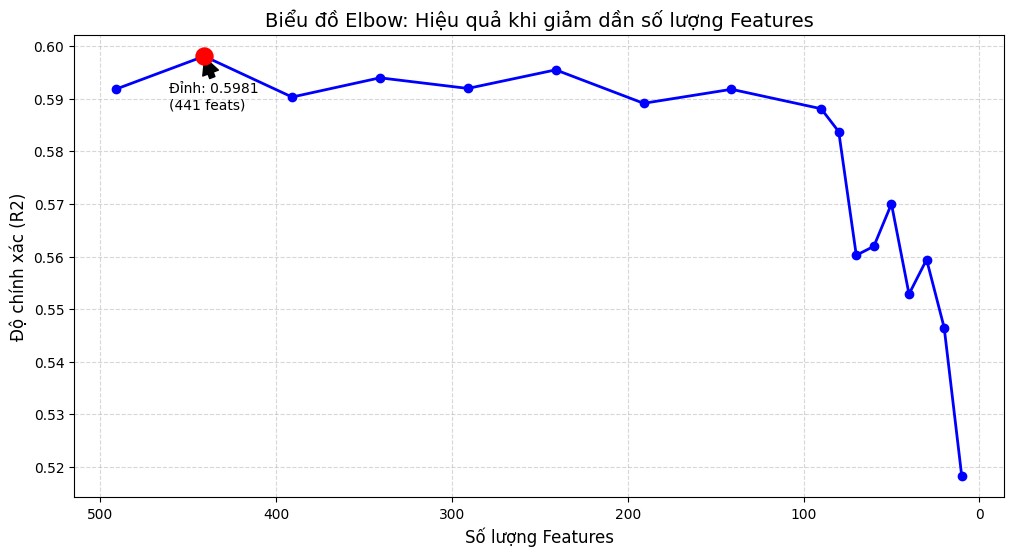


BẢNG XẾP HẠNG (SCORE GIẢM DẦN):
         R2  Num_Features        RMSE
0  0.598089           441  266.934404
1  0.595497           241  267.793825
2  0.593983           341  268.294578
3  0.591965           291  268.960361
4  0.591856           491  268.996203
5  0.591800           141  269.014692
6  0.590324           391  269.500806
7  0.589136           191  269.891156
8  0.588104            90  270.229843
9  0.583754            80  271.652938

BẢNG THEO THỨ TỰ FEATURE (ÍT -> NHIỀU):
    Num_Features        R2        RMSE
16            10  0.518220  292.256370
15            20  0.546470  283.558568
14            30  0.559419  279.481154
13            40  0.552854  281.555517
12            50  0.570011  276.101234
11            60  0.561952  278.676713
10            70  0.560239  279.220899
9             80  0.583754  271.652938
8             90  0.588104  270.229843
7            141  0.591800  269.014692


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from lightgbm import LGBMRegressor

best_params = {
    'learning_rate': 0.01,
    'n_estimators': 2000,
    'num_leaves': 50,
    'max_depth': -1,
    'random_state': 2601,
    'n_jobs': 1,
    'verbose': -1
}

valid_ga_feats = [f for f in list(selected_ga) if f in X_train.columns]

print("Đang xếp hạng features...")
ranker = LGBMRegressor(**best_params)
ranker.fit(X_train[valid_ga_feats], y_train)

imp_df = pd.DataFrame({
    'Feature': valid_ga_feats,
    'Importance': ranker.feature_importances_
}).sort_values(by='Importance', ascending=False)

sorted_feats = imp_df['Feature'].tolist()

steps = list(range(len(sorted_feats), 99, -50)) + list(range(90, 0, -10))
results = []

print(f"\nBắt đầu vòng lặp cắt giảm features ({len(steps)} vòng)...")

for k in steps:
    current_feats = sorted_feats[:k]
    
    model = LGBMRegressor(**best_params)
    model.fit(X_train[current_feats], y_train)
    
    y_pred = model.predict(X_test[current_feats])

    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f"   -> Dùng {k:3d} features: R2 = {r2:.4f} | RMSE = {rmse:.2f}")
    results.append({'Num_Features': k, 'R2': r2, 'RMSE': rmse})


df_results = pd.DataFrame(results).sort_values(by='Num_Features')
df_leaderboard = df_results.sort_values(by='R2', ascending=False).reset_index(drop=True)
csv_filename = 'result/feature_selection_results.csv'
df_results.to_csv(csv_filename, index=False)

plt.figure(figsize=(12, 6))
plt.plot(df_results['Num_Features'], df_results['R2'], marker='o', linewidth=2, color='blue')

best_row = df_results.loc[df_results['R2'].idxmax()]
plt.scatter(best_row['Num_Features'], best_row['R2'], color='red', s=150, zorder=5)
plt.annotate(f"Đỉnh: {best_row['R2']:.4f}\n({int(best_row['Num_Features'])} feats)", 
             (best_row['Num_Features'], best_row['R2']), 
             xytext=(best_row['Num_Features']+20, best_row['R2']-0.01),
             arrowprops=dict(facecolor='black', shrink=0.05))

plt.title('Biểu đồ Elbow: Hiệu quả khi giảm dần số lượng Features', fontsize=14)
plt.xlabel('Số lượng Features', fontsize=12)
plt.ylabel('Độ chính xác (R2)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.gca().invert_xaxis()
plt.show()

print("\nBẢNG XẾP HẠNG (SCORE GIẢM DẦN):")
print(df_leaderboard[['R2', 'Num_Features', 'RMSE']].head(10))

print("\nBẢNG THEO THỨ TỰ FEATURE (ÍT -> NHIỀU):")
print(df_results[['Num_Features', 'R2', 'RMSE']].head(10))